## DATA ANALYSIS

16th March

The goal of this notebook is creating a CNN to analyse previously produced data.

### Packages

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


## DATA renormalization

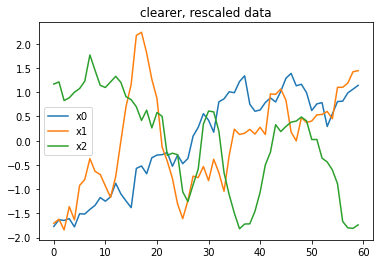

[1. 0. 0.]
10000 8000 2000 60


In [178]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000'
fnamex = 'DATA/x_'+str0+'.csv'
fnamey = 'DATA/y_'+str0+'.csv'

x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
N = len(x)

xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('clearer, rescaled data')
plt.legend()
plt.show()    


categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             #one-hot encoding
print(y[0])


perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

L = len(x[0])
print(N,N_train, N_val,L)


x_train = x_train.reshape(x_train.shape[0],L,1)    #reshaping
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

In [179]:
reg = regularizers.l2(0.01)    #LASSO, lambda = 10e-4
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

model = Sequential()
model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 11,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model.add(AveragePooling1D(5))                          #Reduce 5 -> 1

model.add(Conv1D(                                       #Second layer
                filters = 5,
                kernel_size = 7,
                activation = 'relu'
                ))
model.add(Flatten())                                      #Move to GNN
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary())   #Notice how few parameters!

Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_462 (Conv1D)          (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_154 (Avera (None, 10, 5)             0         
_________________________________________________________________
conv1d_463 (Conv1D)          (None, 4, 5)              180       
_________________________________________________________________
flatten_154 (Flatten)        (None, 20)                0         
_________________________________________________________________
dense_308 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_154 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_309 (Dense)            (None, 3)              

In [180]:

opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)

model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

#after a compilation of the network we save in 'initial.h5' the weight at the beginning
model.save_weights('initial.h5')

In [181]:
batch_size = 250
epochs = 250
fit = model.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 2
               )

Epoch 1/250
32/32 - 1s - loss: 1.0977 - accuracy: 0.3595 - val_loss: 1.0929 - val_accuracy: 0.4210
Epoch 2/250
32/32 - 0s - loss: 1.0910 - accuracy: 0.3864 - val_loss: 1.0862 - val_accuracy: 0.4215
Epoch 3/250
32/32 - 0s - loss: 1.0848 - accuracy: 0.4027 - val_loss: 1.0769 - val_accuracy: 0.4350
Epoch 4/250
32/32 - 0s - loss: 1.0748 - accuracy: 0.4187 - val_loss: 1.0664 - val_accuracy: 0.4550
Epoch 5/250
32/32 - 0s - loss: 1.0642 - accuracy: 0.4345 - val_loss: 1.0508 - val_accuracy: 0.4590
Epoch 6/250
32/32 - 0s - loss: 1.0478 - accuracy: 0.4521 - val_loss: 1.0331 - val_accuracy: 0.4620
Epoch 7/250
32/32 - 0s - loss: 1.0342 - accuracy: 0.4591 - val_loss: 1.0175 - val_accuracy: 0.4800
Epoch 8/250
32/32 - 0s - loss: 1.0158 - accuracy: 0.4771 - val_loss: 0.9967 - val_accuracy: 0.4925
Epoch 9/250
32/32 - 0s - loss: 1.0018 - accuracy: 0.4861 - val_loss: 0.9818 - val_accuracy: 0.5055
Epoch 10/250
32/32 - 0s - loss: 0.9852 - accuracy: 0.4985 - val_loss: 0.9676 - val_accuracy: 0.5185
Epoch 11/

32/32 - 0s - loss: 0.6763 - accuracy: 0.7283 - val_loss: 0.6816 - val_accuracy: 0.7190
Epoch 84/250
32/32 - 0s - loss: 0.6774 - accuracy: 0.7300 - val_loss: 0.6832 - val_accuracy: 0.7205
Epoch 85/250
32/32 - 0s - loss: 0.6759 - accuracy: 0.7268 - val_loss: 0.6806 - val_accuracy: 0.7255
Epoch 86/250
32/32 - 0s - loss: 0.6683 - accuracy: 0.7304 - val_loss: 0.6790 - val_accuracy: 0.7235
Epoch 87/250
32/32 - 0s - loss: 0.6746 - accuracy: 0.7272 - val_loss: 0.6765 - val_accuracy: 0.7235
Epoch 88/250
32/32 - 0s - loss: 0.6727 - accuracy: 0.7314 - val_loss: 0.6783 - val_accuracy: 0.7225
Epoch 89/250
32/32 - 0s - loss: 0.6758 - accuracy: 0.7258 - val_loss: 0.6771 - val_accuracy: 0.7230
Epoch 90/250
32/32 - 0s - loss: 0.6687 - accuracy: 0.7358 - val_loss: 0.6755 - val_accuracy: 0.7280
Epoch 91/250
32/32 - 0s - loss: 0.6642 - accuracy: 0.7330 - val_loss: 0.6743 - val_accuracy: 0.7250
Epoch 92/250
32/32 - 0s - loss: 0.6741 - accuracy: 0.7295 - val_loss: 0.6747 - val_accuracy: 0.7275
Epoch 93/250


Epoch 165/250
32/32 - 0s - loss: 0.6014 - accuracy: 0.7666 - val_loss: 0.5945 - val_accuracy: 0.7670
Epoch 166/250
32/32 - 0s - loss: 0.5927 - accuracy: 0.7675 - val_loss: 0.5903 - val_accuracy: 0.7705
Epoch 167/250
32/32 - 0s - loss: 0.5963 - accuracy: 0.7710 - val_loss: 0.5910 - val_accuracy: 0.7670
Epoch 168/250
32/32 - 0s - loss: 0.5908 - accuracy: 0.7689 - val_loss: 0.5857 - val_accuracy: 0.7715
Epoch 169/250
32/32 - 0s - loss: 0.5891 - accuracy: 0.7703 - val_loss: 0.5863 - val_accuracy: 0.7690
Epoch 170/250
32/32 - 0s - loss: 0.5868 - accuracy: 0.7734 - val_loss: 0.5817 - val_accuracy: 0.7710
Epoch 171/250
32/32 - 0s - loss: 0.5882 - accuracy: 0.7744 - val_loss: 0.5791 - val_accuracy: 0.7770
Epoch 172/250
32/32 - 0s - loss: 0.5819 - accuracy: 0.7766 - val_loss: 0.5840 - val_accuracy: 0.7725
Epoch 173/250
32/32 - 0s - loss: 0.5832 - accuracy: 0.7720 - val_loss: 0.5797 - val_accuracy: 0.7725
Epoch 174/250
32/32 - 0s - loss: 0.5877 - accuracy: 0.7724 - val_loss: 0.5785 - val_accurac

32/32 - 0s - loss: 0.5248 - accuracy: 0.8071 - val_loss: 0.5174 - val_accuracy: 0.8085
Epoch 247/250
32/32 - 0s - loss: 0.5217 - accuracy: 0.7999 - val_loss: 0.5163 - val_accuracy: 0.8050
Epoch 248/250
32/32 - 0s - loss: 0.5189 - accuracy: 0.8037 - val_loss: 0.5189 - val_accuracy: 0.8065
Epoch 249/250
32/32 - 0s - loss: 0.5186 - accuracy: 0.8027 - val_loss: 0.5143 - val_accuracy: 0.8075
Epoch 250/250
32/32 - 0s - loss: 0.5219 - accuracy: 0.8023 - val_loss: 0.5301 - val_accuracy: 0.8025


As we can see now the performance are really better!

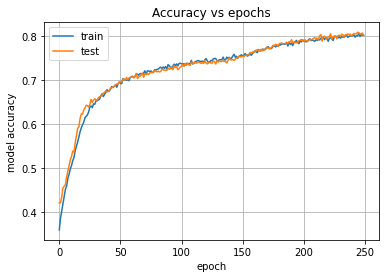

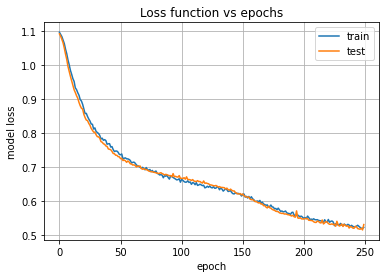

In [182]:
#Plot

# accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()
# loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Loss function vs epochs')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

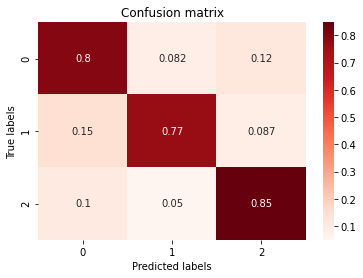

In [183]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_val  = model.predict(x_val)
#take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
sns.heatmap(confusion_Oz, annot = True, cmap = plt.cm.Reds, fmt = '.2g')

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')
plt.show()

100%|██████████| 12/12 [08:41<00:00, 43.44s/it]


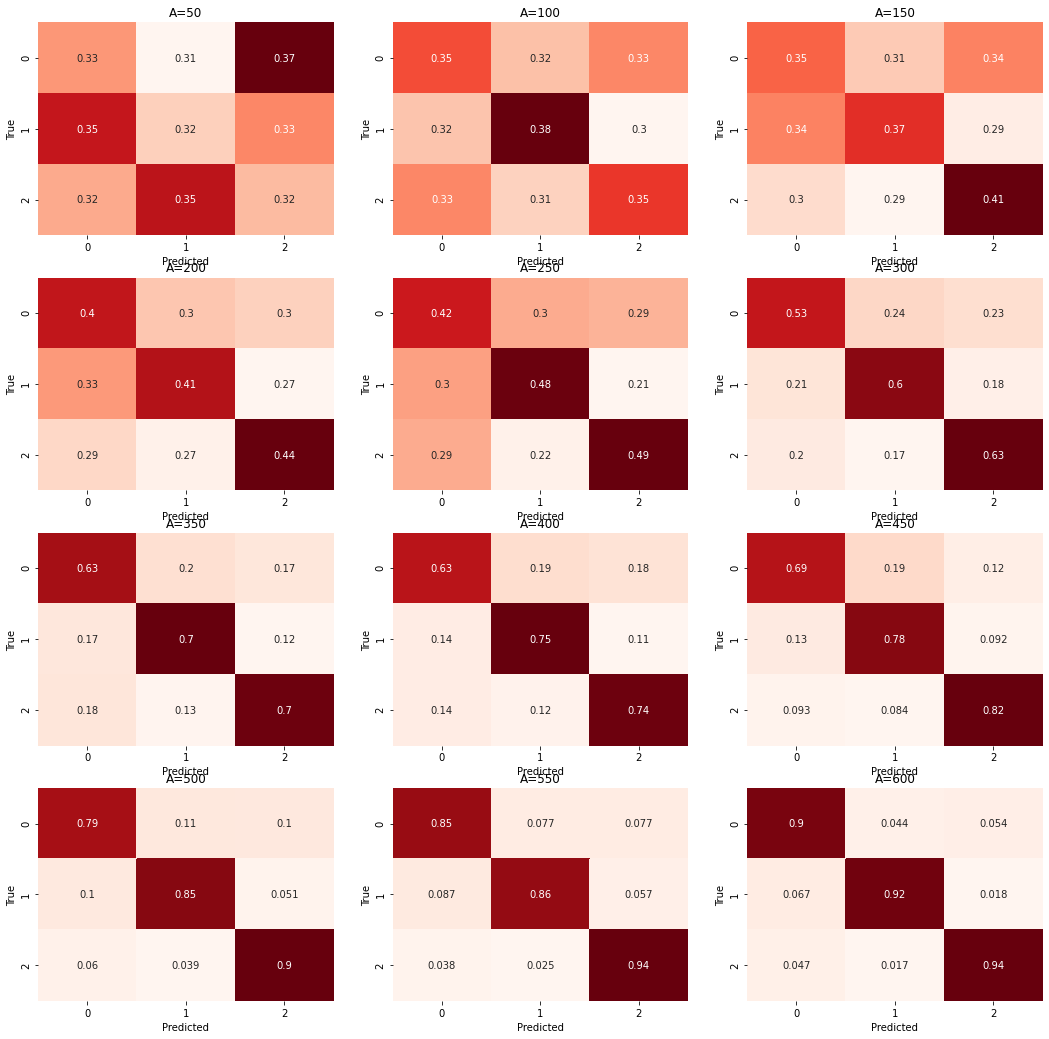

In [184]:
from tqdm import tqdm

fig, ax = plt.subplots(4, 3, figsize=(18,20))
As = np.arange(50,650,50)
scores = {}

for a in tqdm(range(len((As)))):
    
    #if statements to define the grid for the subplots
    if a < 3:
        i = 0
        j = a
    elif a < 6:
        i = 1
        j = a-3
    elif a < 9:
        i = 2
        j = a-6
    elif a < 12:
        i = 3
        j = a-9
    elif a < 15:
        i = 4
        j = a-12
    
    str0 = f'ts_L60_Z12_A{As[a]}_DX50_bias5_N10000'
    fnamex = 'DATA/x_'+str0+'.csv'
    fnamey = 'DATA/y_'+str0+'.csv'
    
    x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
    N = len(x)

    xm = x.mean(axis = 1)
    stdx = x.std(axis = 1)
    for n in range(N):
        x[n] -= xm[n]
        x[n] /= stdx[n]

    categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
    N_categ = np.max(categ)+1
    y = np.zeros((N,N_categ))
    for n in range(N):
        y[n][categ[n]] = 1             

    perc_train = 0.8                    
    N_train = int(N*perc_train)
    N_val = N - N_train

    x_train, y_train = x[:N_train], y[:N_train]
    x_val, y_val = x[N_train:], y[N_train:]

    L = len(x[0])

    x_train = x_train.reshape(x_train.shape[0],L,1)   
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)
    
    #at each step of the for loop we recover the initial weights in order to start always from the same model
    model.load_weights('initial.h5')
    fit = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    scores[As[a]] = np.mean(fit.history['accuracy'][-20:])
    
    y_pred_val  = model.predict(x_val)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    max_y_val = np.argmax(y_val, axis=1)
    confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
 
    g = sns.heatmap(confusion_Oz,
                    annot = True,
                    cmap = plt.cm.Reds,
                    cbar = False,
                    fmt = '.2g',
                    ax = ax[i][j]
                   )
    g.set_ylabel('True')
    g.set_xlabel('Predicted')
    g.set_title(f'A={As[a]}')

plt.show()

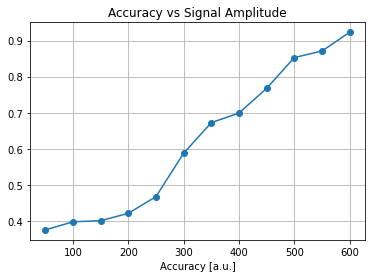

In [185]:
keys_int = []
as_accuracy = []
for k in scores.keys():
    keys_int.append(k)
    as_accuracy.append(scores.get(k))
plt.title('Accuracy vs Signal Amplitude')
plt.xlabel('Signal Amplitude [a.u.]')
plt.xlabel('Accuracy [a.u.]')
plt.plot(keys_int, as_accuracy, '-o')
plt.grid()
plt.show()

# new data

In [187]:
str1 = 'ts_comp_N10000'
fnamex1 = 'DATA/x_'+str1+'.csv'
fnamey1 = 'DATA/y_'+str1+'.csv'

x = np.loadtxt(fnamex1, delimiter = ',', dtype = float)
categ = np.loadtxt(fnamey1, delimiter = ',', dtype = int)

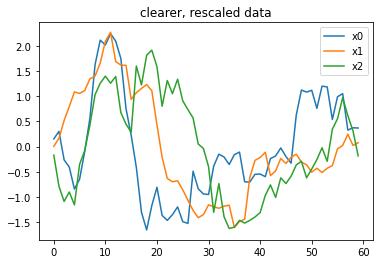

[0. 1. 0.]
Total samples:  10000 
Training samples: 8000 2000 
Test samples: 60


In [188]:
N = len(x)

xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('clearer, rescaled data')
plt.legend()
plt.show()    

N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             #one-hot encoding
print(y[0])


perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

L = len(x[0])
print('Total samples: ', N, '\nTraining samples:',N_train, N_val, '\nTest samples:',L)


x_train = x_train.reshape(x_train.shape[0],L,1)    #reshaping
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)


### keeping just one Conv1d, adding dense

In [201]:
reg = regularizers.l2(0.01)    #LASSO, lambda = 10e-4
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

batch_size = 250
epochs = 250

In [202]:
model1 = Sequential()
model1.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model1.add(AveragePooling1D(4))                          #Reduce 5 -> 1
model1.add(Flatten())                                     #Move to GNN

model1.add(Dense(8,activation = 'relu'))

model1.add(Dropout(0.1))
model1.add(Dense(N_categ,activation = 'softmax'))

print(model1.summary()) 
model1.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count1 = count_params(model1.trainable_weights)

fit1 = model1.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model1.h5'
model1.save(fname, save_format='h5')

Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_476 (Conv1D)          (None, 52, 5)             50        
_________________________________________________________________
average_pooling1d_162 (Avera (None, 13, 5)             0         
_________________________________________________________________
flatten_162 (Flatten)        (None, 65)                0         
_________________________________________________________________
dense_329 (Dense)            (None, 8)                 528       
_________________________________________________________________
dropout_162 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_330 (Dense)            (None, 3)                 27        
Total params: 605
Trainable params: 605
Non-trainable params: 0
______________________________________________________

In [203]:
model2 = Sequential()
model2.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model2.add(AveragePooling1D(4))                          #Reduce 5 -> 1
model2.add(Flatten())                                     #Move to GNN
model2.add(Dense(8,activation = 'relu'))
model2.add(Dense(6,activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(N_categ,activation = 'softmax'))

print(model2.summary()) 
model2.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count2 = count_params(model2.trainable_weights)

fit2 = model2.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model2.h5'
model2.save(fname, save_format='h5')

Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_477 (Conv1D)          (None, 52, 5)             50        
_________________________________________________________________
average_pooling1d_163 (Avera (None, 13, 5)             0         
_________________________________________________________________
flatten_163 (Flatten)        (None, 65)                0         
_________________________________________________________________
dense_331 (Dense)            (None, 8)                 528       
_________________________________________________________________
dense_332 (Dense)            (None, 6)                 54        
_________________________________________________________________
dropout_163 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_333 (Dense)            (None, 3)              

In [204]:
model3 = Sequential()
model3.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model3.add(AveragePooling1D(4))                          #Reduce 5 -> 1
model3.add(Flatten())                                     #Move to GNN
model3.add(Dense(8,activation = 'relu'))
model3.add(Dense(6,activation = 'relu'))
model3.add(Dense(3,activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(N_categ,activation = 'softmax'))

print(model3.summary()) 

model3.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count3 = count_params(model3.trainable_weights)

fit3 = model3.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model3.h5'
model3.save(fname, save_format='h5')

Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_478 (Conv1D)          (None, 52, 5)             50        
_________________________________________________________________
average_pooling1d_164 (Avera (None, 13, 5)             0         
_________________________________________________________________
flatten_164 (Flatten)        (None, 65)                0         
_________________________________________________________________
dense_334 (Dense)            (None, 8)                 528       
_________________________________________________________________
dense_335 (Dense)            (None, 6)                 54        
_________________________________________________________________
dense_336 (Dense)            (None, 3)                 21        
_________________________________________________________________
dropout_164 (Dropout)        (None, 3)              

In [205]:
model4 = Sequential()
model4.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                )
          )
model4.add(AveragePooling1D(4))                          #Reduce 5 -> 1
model4.add(Flatten())                                     #Move to GNN
model4.add(Dense(8,activation = 'relu'))
model4.add(Dense(6,activation = 'relu'))
model4.add(Dense(3,activation = 'relu'))
model4.add(Dense(3,activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(N_categ,activation = 'softmax'))

print(model4.summary()) 

model4.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count4 = count_params(model4.trainable_weights)

fit4 = model4.fit(x_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data = (x_val,y_val),
                  verbose = 0
                   )

!mkdir MODEL
fname ='MODEL/model4.h5'
model4.save(fname, save_format='h5')

Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_479 (Conv1D)          (None, 52, 5)             50        
_________________________________________________________________
average_pooling1d_165 (Avera (None, 13, 5)             0         
_________________________________________________________________
flatten_165 (Flatten)        (None, 65)                0         
_________________________________________________________________
dense_338 (Dense)            (None, 8)                 528       
_________________________________________________________________
dense_339 (Dense)            (None, 6)                 54        
_________________________________________________________________
dense_340 (Dense)            (None, 3)                 21        
_________________________________________________________________
dense_341 (Dense)            (None, 3)              

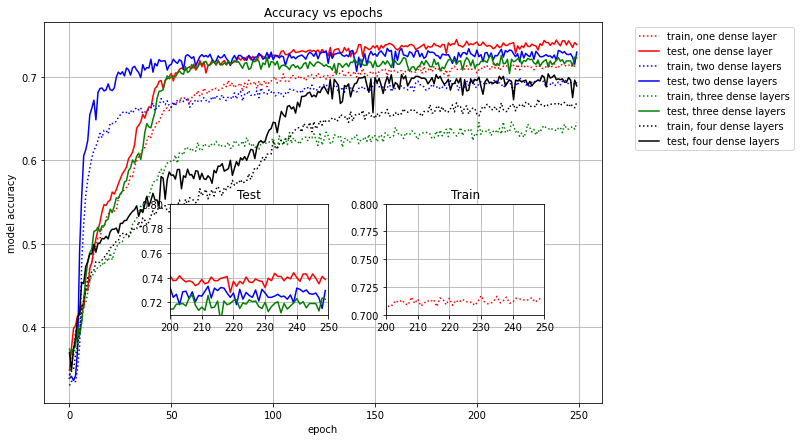

In [206]:
plt.figure(figsize=(10,7))

plt.plot(fit1.history['accuracy'], label='train, one dense layer', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, one dense layer', c='r')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.ylabel('model accuracy')
plt.xlabel('epoch')

plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.plot(fit4.history['accuracy'], label='train, four dense layers', c='black', ls='dotted')
plt.plot(fit4.history['val_accuracy'], label='test, four dense layers', c='black')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05, 1))

# test additional axes
a = plt.axes([.3, .3, .22, .22])
plt.plot(fit1.history['val_accuracy'], label='test, one dense layers', c='r')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.plot(fit4.history['val_accuracy'], label='test, four dense layers', c='black')
plt.title('Test')
plt.xlim(200,250)
plt.ylim(0.71,0.8)
plt.grid()

# train additional axes
a = plt.axes([.6, .3, .22, .22])
plt.plot(fit1.history['accuracy'], label='train, one dense layers', c='r', ls='dotted')
plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit4.history['accuracy'], label='train, four dense layers', c='black', ls='dotted')
plt.title('Train')
plt.xlim(200,250)
plt.ylim(0.7,0.8)

plt.grid()
plt.show()

Se ogni dense layer è un classificatore lineare, aggiungere classificatori lineari a classificatori lineari è forse poco sensato.

'Ci prepariamo ad avere 3 output'. Con 10 layer continui continui a rimescolare la stessa informazione. Quindi facciamo 10. 10,7. 10,7,5. 10,7,5,3. 

Primo layer: separatore lineare: se un solo filtro ho 10 modelli che fanno sep lineare su un solo filtro. In quanti modi diversi separazine lineare su 5 dati (?). Se ho un campione più grande ecco che separazione lineare migliore. 

Più di due categorie: one vs one, one vs all. One vs all? Con 3 categorie la cosa più comonda numero di neuroni in un layer multiplo di 3? proviamo

Con numero dispari di Dense meglio, con un numero pari peggio

Proviamo a mettere a 9. 9,7. 9,7,5. 9,7,5,3. Ovvero mettere un numero multiplo di N_categ. 2 dense, 3 dense e 4 dense ora si overlappano come performance e va sopra a tutti quello con 1. A livello di train sono praticamente uguali.

Proviamo a mettere a 9. 9,6. 9,6,3. 9,6,3,3. Scheramata 15:56


Proviamo a togliere il dropout. Schermata 16:00. Siamo abbastanza convinti nel dire che basta solamente un dense layer perché è quello che mediamente ha performato meglio di tutti.

Proviamo a mettere il dropour a 0.1.  Qui le cose vanno decisamente meglio che se non 0.2

Proviamo con il dropout a 0.2 dopo il flatten. 

Proviamo a cambiare su model 1 le activation functions in tanh e elu e peggiora.

### adding conv1d

In [195]:
model5 = Sequential()
model5.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model5.add(AveragePooling1D(4)) #Reduce 5 -> 1

model5.add(Conv1D(filters=5, kernel_size=7, activation=
                'relu'))

model5.add(Flatten())                                     #Move to GNN
model5.add(Dense(8,activation = 'relu'))
model5.add(Dropout(0.2))
model5.add(Dense(N_categ,activation = 'softmax'))

print(model5.summary()) 


model5.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count5 = count_params(model5.trainable_weights)

fit5 = model5.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model5.h5'
model5.save(fname, save_format='h5')

Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_471 (Conv1D)          (None, 52, 5)             50        
_________________________________________________________________
average_pooling1d_160 (Avera (None, 13, 5)             0         
_________________________________________________________________
conv1d_472 (Conv1D)          (None, 7, 5)              180       
_________________________________________________________________
flatten_160 (Flatten)        (None, 35)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 8)                 288       
_________________________________________________________________
dropout_160 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_326 (Dense)            (None, 3)              

In [196]:
model6 = Sequential()
model6.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model6.add(AveragePooling1D(4)) #Reduce 5 -> 1

model6.add(Conv1D(filters=5, kernel_size=7, activation=
                'relu'))

model6.add(Conv1D(filters=5, kernel_size=4, activation=
                'relu'))

model6.add(Flatten())                                     #Move to GNN
model6.add(Dense(8,activation = 'relu'))
model6.add(Dropout(0.2))
model6.add(Dense(N_categ,activation = 'softmax'))

print(model6.summary()) 



model6.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count6 = count_params(model6.trainable_weights)

fit6 = model6.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model6.h5'
model6.save(fname, save_format='h5')

Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_473 (Conv1D)          (None, 52, 5)             50        
_________________________________________________________________
average_pooling1d_161 (Avera (None, 13, 5)             0         
_________________________________________________________________
conv1d_474 (Conv1D)          (None, 7, 5)              180       
_________________________________________________________________
conv1d_475 (Conv1D)          (None, 4, 5)              105       
_________________________________________________________________
flatten_161 (Flatten)        (None, 20)                0         
_________________________________________________________________
dense_327 (Dense)            (None, 8)                 168       
_________________________________________________________________
dropout_161 (Dropout)        (None, 8)              

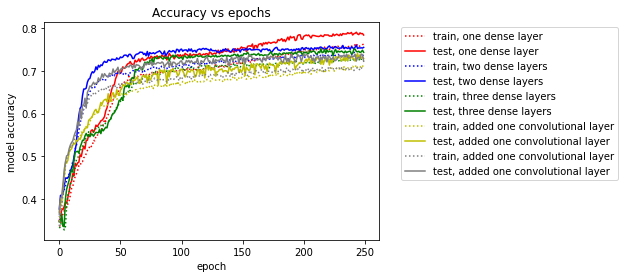

In [197]:
plt.plot(fit1.history['accuracy'], label='train, one dense layer', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, one dense layer', c='r')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.ylabel('model accuracy')
plt.xlabel('epoch')



plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.ylabel('model accuracy')
plt.xlabel('epoch')

plt.grid()

plt.plot(fit5.history['accuracy'], label='train, added one convolutional layer', c='y', ls='dotted')
plt.plot(fit5.history['val_accuracy'], label='test, added one convolutional layer', c='y')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()


plt.plot(fit6.history['accuracy'], label='train, added one convolutional layer', c='grey', ls='dotted')
plt.plot(fit6.history['val_accuracy'], label='test, added one convolutional layer', c='grey')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


In [200]:
trainable_count = [trainable_count1, trainable_count2, trainable_count3, trainable_count4, trainable_count5, trainable_count6]
print(trainable_count)

[324, 375, 387, 387, 545, 530]


## Regularization 

  0%|          | 0/12 [00:00<?, ?it/s]

mkdir: MODEL: File exists


  8%|▊         | 1/12 [00:46<08:29, 46.27s/it]

mkdir: MODEL: File exists


 17%|█▋        | 2/12 [01:31<07:34, 45.47s/it]

mkdir: MODEL: File exists


 25%|██▌       | 3/12 [02:17<06:51, 45.72s/it]

mkdir: MODEL: File exists


 33%|███▎      | 4/12 [03:05<06:15, 46.93s/it]

mkdir: MODEL: File exists


 42%|████▏     | 5/12 [03:52<05:27, 46.75s/it]

mkdir: MODEL: File exists


 50%|█████     | 6/12 [04:38<04:39, 46.55s/it]

mkdir: MODEL: File exists


 58%|█████▊    | 7/12 [05:22<03:48, 45.71s/it]

mkdir: MODEL: File exists


 67%|██████▋   | 8/12 [06:07<03:02, 45.51s/it]

mkdir: MODEL: File exists


 75%|███████▌  | 9/12 [06:55<02:19, 46.36s/it]

mkdir: MODEL: File exists


 83%|████████▎ | 10/12 [07:39<01:31, 45.63s/it]

mkdir: MODEL: File exists


 92%|█████████▏| 11/12 [08:25<00:45, 45.56s/it]

mkdir: MODEL: File exists


100%|██████████| 12/12 [09:10<00:00, 45.90s/it]


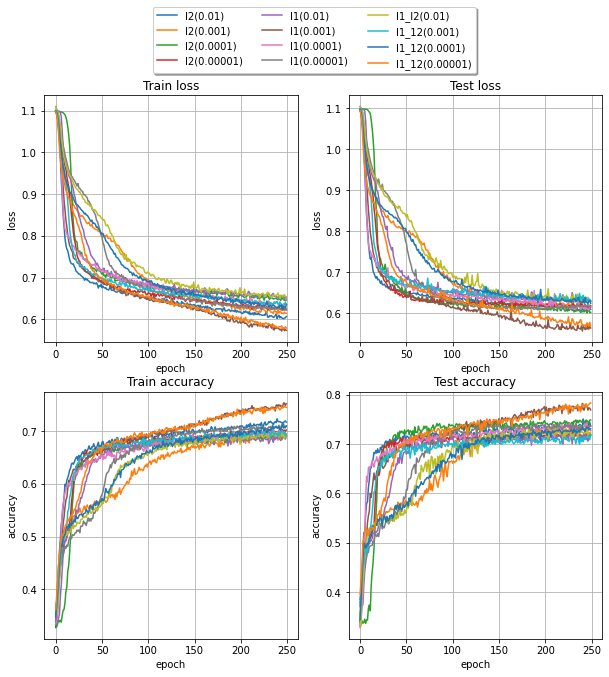

[73.60000014305115, 72.69999980926514, 74.84999895095825, 71.8500018119812, 71.70000076293945, 76.8999993801117, 72.69999980926514, 73.60000014305115, 72.25000262260437, 71.8999981880188, 73.1000006198883, 78.29999923706055]


In [240]:
from tqdm import tqdm
epochs = 250


def get_model(k_reg):
    model = Sequential()
    model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 9,                       #like Z = 12
                kernel_regularizer = k_reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

    model.add(AveragePooling1D(4)) #Reduce 5 -> 1

    model.add(Conv1D(filters=5, kernel_size=7, activation=
                'relu'))

    model.add(Conv1D(filters=5, kernel_size=4, activation=
                'relu'))

    model.add(Flatten())                                     #Move to GNN
    model.add(Dense(8,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ,activation = 'softmax'))

    model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

    
    return model

# list of allowed optional arguments for the optimizer, see compile_model()

#dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
#batch_size = [60, 300, 500]

#learning_rate = [0.05, 0.1, 0.5]


k_reg = [ 
          regularizers.l2(0.01),
          regularizers.l2(0.001),
          regularizers.l2(0.0001),
          regularizers.l2(0.00001),
          regularizers.l1(0.01),
          regularizers.l1(0.001),
          regularizers.l1(0.0001),
          regularizers.l1(0.00001),
          regularizers.l1_l2(0.01),
          regularizers.l1_l2(0.001),
          regularizers.l1_l2(0.0001),
          regularizers.l1_l2(0.00001)
        ]

vals = ['l2(0.01)','l2(0.001)','l2(0.0001)','l2(0.00001)',
        'l1(0.01)','l1(0.001)','l1(0.0001)','l1(0.00001)',
        'l1_l2(0.01)','l1_l2(0.001)','l1_l2(0.0001)','l1_l2(0.00001)']
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0][0].set_title('Train loss')
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('loss')
ax[0][0].grid()
ax[0][1].set_title('Test loss')
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('loss')
ax[0][1].grid()
ax[1][0].set_title('Train accuracy')
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('accuracy')
ax[1][0].grid()
ax[1][1].set_title('Test accuracy')
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('accuracy')
ax[1][1].grid()


cvscores = []
for i in tqdm(range(len(k_reg))):
    model = get_model(k_reg[i])
    model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
                  optimizer = 'adam', metrics = ['accuracy'])

    fit = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    
    scores = model.evaluate(x_val, y_val, verbose=0)
    cvscores.append(scores[1] * 100)
    !mkdir MODEL
    fname ='MODEL/model_reg_' + vals[i] +'.h5'
    model.save(fname, save_format='h5')
    
    
    ax[0][0].plot(fit.history['loss'], label=vals[i])
    ax[0][1].plot(fit.history['val_loss'], label=vals[i])
    ax[1][0].plot(fit.history['accuracy'], label=vals[i])
    ax[1][1].plot(fit.history['val_accuracy'], label=vals[i])


lines_labels = [ax[0][1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01),
          ncol=3, fancybox=True, shadow=True)

plt.show()

print(cvscores)

    

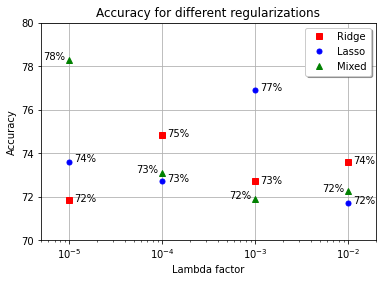

In [248]:
X = [0.01,0.001,0.0001, 0.00001]
Y1, Y2, Y3 = np.array(cvscores).reshape(3,4)
Z = ['Ridge','Lasso','Mixed']

plt.title('Accuracy for different regularizations')
plt.ylabel('Accuracy')
plt.xlabel('Lambda factor')
plt.xscale('log')
plt.grid()
plt.xlim([5*1e-6,2e-2])
plt.ylim([70,80])
plt.plot(X, Y1,'rs', label = Z[0])
plt.plot(X, Y2,'b.', markersize = 10, label = Z[1])
plt.plot(X, Y3,'g^', label = Z[2])

for i, v in zip(X,Y1):
    plt.text(i*1.5, v*0.999, '{:.0f}%'.format(v), ha="center")
for i, v in zip(X,Y3):
    plt.text(i*0.7, v, '{:.0f}%'.format(v), ha="center")
for i, v in zip(X,Y2):
    plt.text(i*1.5, v, '{:.0f}%'.format(v), ha="center")

plt.legend(loc=1, fancybox=True, shadow=True)
plt.show()

			prova conv1d_639 (9, 1, 5)


			prova conv1d_640 (7, 5, 5)


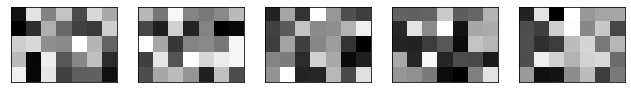

			prova conv1d_641 (4, 5, 5)


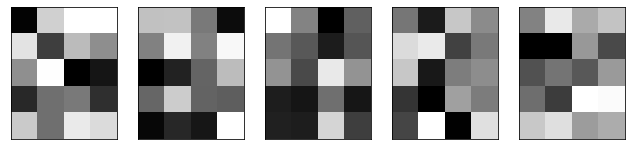

In [255]:
best_loss = regularizers.l1_l2(1e-5)
worst_loss = regularizers.l1(0.01)

model1_before = get_model(best_loss)
model1_after = tensorflow.keras.models.load_model('MODEL/model_reg_l1_12(0.0001).h5')
model2_before = get_model(worst_loss)
model2_after = tensorflow.keras.models.load_model('MODEL/model_reg_l1(0.01).h5')

def print_filters(model_b, model_name = 'Model'):
    for layer in model_b.layers:
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # get filter weights
        filters, biases = layer.get_weights()
        #renormalize
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        n_filters, ix = len(filters[0][0]), 1
        #define figure
        fig, ax = plt.subplots(1, n_filters, sharey = True, figsize = (11,22))
        print('\t\t\t'+model_name,layer.name, filters.shape)
        for i in range(n_filters):
            # get the filter
            f = np.array(filters[:,:,i]).T
            # plot each channel separately
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            a = ax[i].imshow(f, cmap='gray')
            ix += 1
            if i == n_filters:
                cbar = fig.colorbar(a, orientation ='horizontal', ax=ax[i])
                cbar.solids.set_edgecolor("face")
                plt.draw()
        plt.show()
    # show the figure
    
    plt.show()
    
p = print_filters(model1_before, 'prova')

<AxesSubplot:>

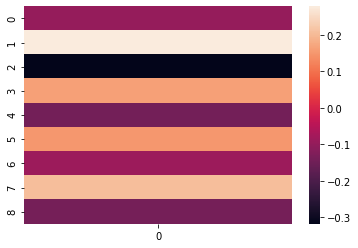

In [258]:
w_first_CONV1D = model.layers[0].get_weights()[0]
sns.heatmap(w_first_CONV1D[:,:,0])

In [20]:
!mkdir MODEL
fname ='MODEL/model'+str0+'.h5'
model.save(fname, save_format='h5')

model2 = keras.models.load_model(fname)
yhat_val = np.argmax(model2.predict(x_val), axis=-1)
ytrue_val = np.argmax(y_val, axis=-1)

for n in range(20):
    print(y_val[n], ytrue_val[n], yhat_val[n])

NameError: name 'str0' is not defined